## Joint transformations in Pytorch
Before feeding a neural network, you may want to perfom a sort of data augmentation through random transformations. In problems like semantic segmentation, you would like to be sure that all the data corresponding to a given image instance are read and transformed the same way (e.g., you want to random crop the radiometric image and the ground truth at the same location). However, random transformations as defined in Pytorch will be random per image. As a result, there is a high chance that an image and its ground truth won't be crop at the same location when using a random crop (or any other random operation). Note that this phenomenon is also true for more than 2 images (e.g., you have optical and multispectral data as well as a ground truth segmentation but you did not stack them for any possible reason - yet all of them should be modified the same way).

A very neat approach to solve this problem is to merge (concatenate) all the images corresponding to a data point (ground truth, image, segmentation, etc.) in the channels dimension, then to apply the transform on the whole stack before to split the data again. 

Following code is based https://github.com/pytorch/vision/issues/9 . It proposes to merge all the images in the channel dimension before applying the transform on the whole stack of images. The major limitation of this approach is that we need to redefine the transformation used in the transforms module of Pytorch. Indeed, Pytorch is based on pillow images (PIL), but PIL does not accept more than 4 channels per image and thus can't transform images with more than 4 channels. As a result, default transformations cannot be used with a huge stack of images: We need to rewrite them with Numpy+OpenCV (see next section).

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import math
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [64]:
class EnhancedCompose(object):
    """Composes several transforms together, support separate transformations for multiple input.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            if isinstance(t, collections.Sequence):
                assert isinstance(img, collections.Sequence) and len(img) == len(t), "size of image group and transform group does not fit"
                tmp_ = []
                for i, im_ in enumerate(img):
                    if callable(t[i]):
                        tmp_.append(t[i](im_))
                    else:
                        tmp_.append(im_)
                img = tmp_
            elif callable(t):
                img = t(img)
            elif t is None:
                continue
            else:
                raise Exception('unexpected type')                
        return img

class Merge(object):
    """Merge a group of images along channels dimensions. 
    
    Count is the number of images to be merged starting from the first one.
    If count < len(images), then only the first count images are merge along the
    channels dimension. The merged image is put in an array, and the other are
    appended to this array as a subarray. 
    Example: [im1, im2, im2], count=2  --> [ merged(im1,im2) , [im3]] 
    
    """
    def __init__(self, count=-1, axis=-1):
        self.axis  = axis
        self.count = count
    def __call__(self, images):
        if isinstance(images, collections.Sequence) or isinstance(images, np.ndarray):
            assert all([isinstance(i, np.ndarray) for i in images]), 'only numpy array is supported'
            shapes = [list(i.shape) for i in images]
            for s in shapes:
                s[self.axis] = None
            assert all([s==shapes[0] for s in shapes]), 'shapes must be the same except the merge axis'
            if(self.count > 0):
                merged = np.concatenate(images[0:min(self.count, len(images))], axis=self.axis)
                if(self.count < len(images)):
                    tab_output = [merged]
                    tab_output.append(images[self.count:len(images)])
                    return tab_output
                else:
                    return merged
            else:
                merged = np.concatenate(images, axis=self.axis)
                return merged
        else:
            raise Exception("obj is not a sequence (list, tuple, etc)")
        
class Split(object):
    """Split images into individual images
    """
    def __init__(self, *slices, **kwargs):
        assert isinstance(slices, collections.Sequence)
        slices_ = []
        for s in slices:
            if isinstance(s, collections.Sequence):
                slices_.append(slice(*s))
            else:
                slices_.append(s)
        assert all([isinstance(s, slice) for s in slices_]), 'slices must be consist of slice instances'
        self.slices = slices_
        self.axis = kwargs.get('axis', -1)

    def __call__(self, image):
        ret = []
        for s in self.slices:
            sl = [slice(None)]*image.ndim
            sl[self.axis] = s
            ret.append(image[sl])
        return ret

# Define numpy ready transform functions
Because PIL cannot handle images with more than 4 channels, we need to rewrite all useful transformation using numpy to use above code. Long but worth it !
These functions are used to transform our data. 
We reimplement some functional transforms for a numpy interface instead of a PIL interface. The problem with PIL Interface is that PIL images cannot be used with more than 4 channels.
<br> Original source code : 
https://github.com/pytorch/vision/blob/master/torchvision/transforms/functional.py

#### First, functionals
Following Pytorch architecture, we will first define some functionals that will later be used by transform classes.

In [65]:
def crop(img, i, j, h, w):
    """Crop the given Numpy Array.
    Preserve number of channels.
    Args:
        img (Numpy Array): Image to be cropped.
        i (int): i in (i,j) i.e coordinates of the upper left corner.
        j (int): j in (i,j) i.e coordinates of the upper left corner.
        h (int): Height of the cropped image.
        w (int): Width of the cropped image.
    Returns:
        Numpy Array: Cropped array.
    """
    if not isinstance(img, np.ndarray):
        raise TypeError('img should be a numpy array. Got {}'.format(type(img)))
    return img[j:j+w, i:i+h, :]

def center_crop(img, output_size):
    """Crop the given Numpy Array around its WxH center.
       Preserve number of channels.
    Args:
        img (Numpy Array)    : Image to be cropped.
        output_size (integer): Size of the square crop.
    Returns:
        Numpy Array: Cropped array.
    """
    w, h = img.shape[0], img.shape[1]
    th, tw = output_size, output_size
    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return  crop(img, i, j, th, tw)

def resized_crop(img, i, j, h, w, size, interpolation=cv2.INTER_LINEAR):
    """Crop the given numpy array and resize it to desired size.
        Notably used in :class:`RandomResizedCrop`.
        Args:
            img (Numpy Array) : Image to be cropped.
            i (int): i in (i,j) i.e coordinates of the upper left corner
            j (int): j in (i,j) i.e coordinates of the upper left corner
            h (int): Height of the cropped image.
            w (int): Width of the cropped image.
            size (sequence or int): Desired output size. Same semantics as ``resize``.
            interpolation (int, optional): Desired interpolation. OpenCV is used for this.
            Default is ``bilinear`` with ``cv2.INTER_LINEAR``.
        Returns:
            Numpy Array: Cropped-resized image.
    """
    assert isinstance(img, np.ndarray),'img should be Numpy array'
    img = crop(img, i, j, h, w)
    img = cv2.resize(img, dsize=size, interpolation=interpolation)
    return img

def hflip(img):
    """Horizontally flip the given Numpy Array
    Args:
        img (Numpy Array): Image to be flipped.
    Returns:
        Numpy Array:  Horizontally flipped image.
    """
    if not isinstance(img, np.ndarray):
        raise TypeError('img should be Numpy array: Got {}'.format(type(img)))
    return cv2.flip( img, 0 )

def vflip(img):
    """Vertically flip the given Numpy Array
    Args:
        img (Numpy Array): Image to be flipped.
    Returns:
        Numpy Array:  Vertically flipped image.
    """
    if not isinstance(img, np.ndarray):
        raise TypeError('img should be Numpy array: Got {}'.format(type(img)))
    return cv2.flip( img, 1 )

#### Second, transfrom classes
Now, we will define the classes the will make use of our functionals

In [66]:
class CenterCrop(object):
    """Crops the given Numpy Array at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        """
        Args:
            img (Numpy Array): Image to be cropped.
        Returns:
            Numpy Array: Cropped image.
        """
        return center_crop(img, self.size)

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)
    

class RandomResizedCrop(object):
    """Crop the given Numpy Array Image to random size and aspect ratio.
        A crop of random size (default: of 0.08 to 1.0) of the original size and a random
        aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
        is finally resized to given size.
        This is popularly used to train the Inception networks.
        Args:
            size: expected output size of each edge
            scale: range of size of the origin size cropped
            ratio: range of aspect ratio of the origin aspect ratio cropped
            interpolation: Default: cv2.INTER_LINEAR
    """
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=cv2.INTER_LINEAR):
        if isinstance(size, tuple):
            self.size = size
        else:
            self.size = (size, size)
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("range should be of kind (min, max)")
        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio
        
    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
            Args:
                img (Numpy array): Image to be cropped.
                scale (tuple): range of size of the origin size cropped
                ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
            Returns:
                tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                    sized crop.
        """
        area = img.shape[0] * img.shape[1]
        for attempt in range(10):
            target_area = random.uniform(*scale) * area
            log_ratio = (math.log(ratio[0]), math.log(ratio[1]))
            aspect_ratio = math.exp(random.uniform(*log_ratio))
            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))
            print(w,h)
            if w <= img.shape[0] and h <= img.shape[1]:
                i = random.randint(0, img.shape[1] - h)
                j = random.randint(0, img.shape[0] - w)
                return i, j, h, w
        
        # Fallback to central crop
        in_ratio = img.shape[0] / img.shape[1]
        if (in_ratio < min(ratio)):
            w = img.shape[0]
            h = int(round(w / min(ratio)))
        elif (in_ratio > max(ratio)):
            h = img.shape[1]
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = img.shape[0]
            h = img.shape[1]
        
        i = (img.shape[1] - h) // 2
        j = (img.shape[0] - w) // 2
        return i, j, h, w
    
    def __call__(self, img):
        """
        Args:
            img (Numpy Array): Image to be cropped and resized.
        Returns:
            Numpy Array: Randomly cropped and resized image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return resized_crop(img, i, j, h, w, self.size, self.interpolation)

    def __repr__(self):
        interpolate_str = str(self.interpolation) # number for OpenCV enum / should be map to names
        format_string = self.__class__.__name__ + '(size={0}'.format(self.size)
        format_string += ', scale={0}'.format(tuple(round(s, 4) for s in self.scale))
        format_string += ', ratio={0}'.format(tuple(round(r, 4) for r in self.ratio))
        format_string += ', interpolation={0})'.format(interpolate_str)
        return format_string
    
class RandomHorizontalFlip(object):
    """Horizontally flip the given Numpy Array randomly with a given probability.
        Args:
            p (float): probability of the image being flipped. Default value is 0.5
    """
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, img):
        """
            Args:
                img (Numpy Array): Image to be flipped.
            Returns:
                Numpy Array: Randomly flipped image.
        """
        if random.random() < self.p:
            return hflip(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)
    
class RandomVerticalFlip(object):
    """Vertically flip the given Numpy Array randomly with a given probability.
        Args:
            p (float): probability of the image being flipped. Default value is 0.5
    """
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, img):
        """
            Args:
                img (Numpy Array): Image to be flipped.
            Returns:
                Numpy Array: Randomly flipped image.
        """
        if random.random() < self.p:
            return vflip(img)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(p={})'.format(self.p)

## Test our implementation on demo data

146 191
(25, 25, 6) (25, 25, 3)


/home/remi1/Jupyter/jupyter-env/lib/python3.5/site-packages/ipykernel_launcher.py:80: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


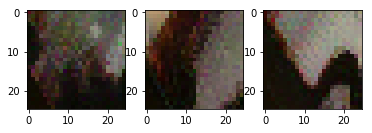

In [86]:
# Load thre images
im1 = io.imread("demo_img/img_11.png")
im2 = io.imread("demo_img/img_13.png") 
im3 = io.imread("demo_img/img_15.png") 
ims = [im1, im2, im3]

# Define our transformation : 
# first merge, 
# second transform, 
# third split keeping first 2 images together 
transform = transforms.Compose([
    Merge(3),
    RandomResizedCrop(25),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    Split([0,6], [6,9]),
])
res = transform(ims)
print(res[0].shape, res[1].shape)


# Split the first two images
# that were let together
spliter = transforms.Compose([
    Split([0,3], [3,6])
])
vis = spliter(res[0])

# Visualize cropping result
plt.figure()
plt.subplot(1,3,1)
plt.imshow(vis[0])
plt.subplot(1,3,2)
plt.imshow(vis[1])
plt.subplot(1,3,3)
plt.imshow(res[1])